## Import everything and setup auto reload 

In [1]:
%reload_ext autoreload 
%autoreload 2 
%matplotlib inline 

In [2]:
import os, sys
PATH = "data/dogscats/"
print(PATH)

from fastai.imports import *
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.dataset import * 
from fastai.sgdr import * 
from fastai.plots import * 

data/dogscats/


In [3]:
sz=224 

## Examine Cat pictures 

In [4]:
!ls {PATH}

models	sample	test1  train  valid


In [5]:
!ls {PATH}valid

cats  dogs


In [8]:
files = !ls {PATH}valid/cats | head 
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

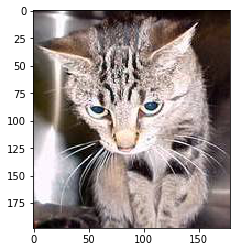

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)
img.shape
img[:4, :4]

In [10]:
img.shape

(198, 179, 3)

In [11]:
img[:4, :4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

# Load resnet34 architecture

In [12]:
arch=resnet34 
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn=ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ubuntu/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 18427577.41it/s]


100%|██████████| 32/32 [00:05<00:00,  6.32it/s]


A Jupyter Widget

  0%|          | 0/360 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.       0.0405   0.0279   0.99121]                         
[ 1.       0.03728  0.02555  0.98926]                          
[ 2.       0.04269  0.02527  0.98975]                          



In [13]:
data.val_y 

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
data.classes

['cats', 'dogs']

# Examine the training and how good it was 

In [15]:
log_preds = learn.predict()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [17]:
log_preds.shape

(2000, 2)

In [34]:
log_preds[30:40]

array([[ -0.00014,  -8.90291],
       [ -0.00029,  -8.16154],
       [ -0.00001, -11.15394],
       [ -0.00049,  -7.62098],
       [ -0.00022,  -8.41411],
       [ -0.00001, -12.12679],
       [ -0.00473,  -5.35702],
       [ -0.00004, -10.18936],
       [ -0.00001, -11.50503],
       [ -0.00002, -11.0517 ]], dtype=float32)

In [24]:
# Now take it to 0 or 1 all the predictions 
preds = np.argmax(log_preds, axis=1)

In [35]:
preds[30:40]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
probs=np.exp(log_preds[:,1]) # prob it is a dog. Use only the second index afterwards. 

In [40]:
probs[30:40]

array([ 0.00014,  0.00029,  0.00001,  0.00049,  0.00022,  0.00001,  0.00471,  0.00004,  0.00001,  0.00002], dtype=float32)

In [41]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)

In [43]:
# is_correct is a boolean that is True or False and compares against the boolean 
# comparing the predictions with the actual values in y 
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y) == is_correct)

In [45]:
# Plotting the value with titles 
def plot_val_with_title(idxs,title): 
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    print(imgs)
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles = title_prob) 
    

In [46]:
# Normal plot functions 
def plots(ims, figsize=(12, 6), rows=1, titles=None): 
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp= f.add_subplot(rows, len(ims) // rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])        

In [48]:
# Load img ids 
# Plot val with titles 
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH + ds.fnames[idx]))


In [51]:
# Plot value with title 
def plot_val_with_title(idxs, title): 
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs=[probs[x] for x in idxs]
    print(title) 
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


Correctly classified


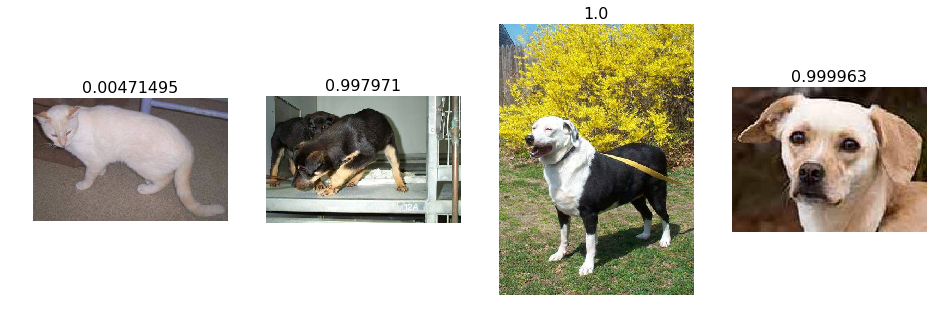

In [52]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly Classified


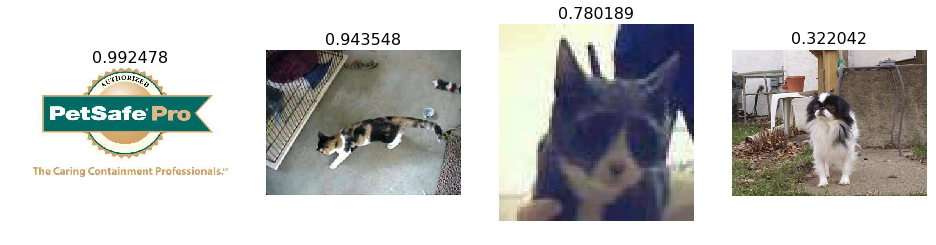

In [55]:
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

In [56]:
def most_by_mask(mask, mult): 
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

In [63]:
def most_by_correct(y, is_correct): 
    mult=-1 if (y==1) == is_correct else 1 
    return most_by_mask((preds == data.val_y) == is_correct & (data.val_y == y ), mult)

Most correct cats 


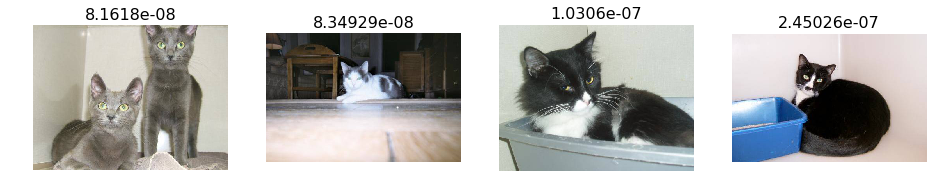

In [64]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats ")

Most correct dogs


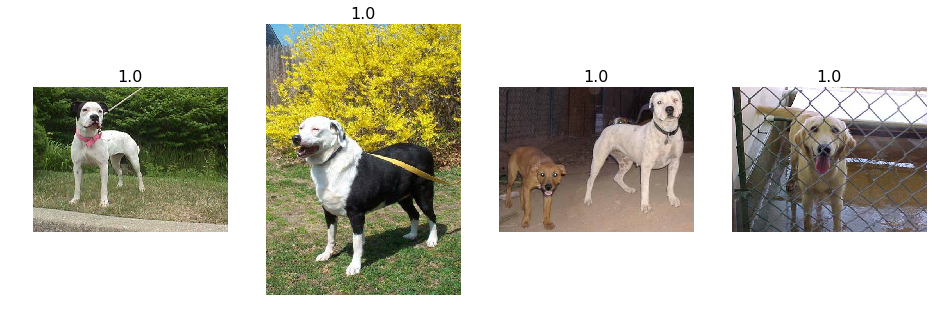

In [65]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats 


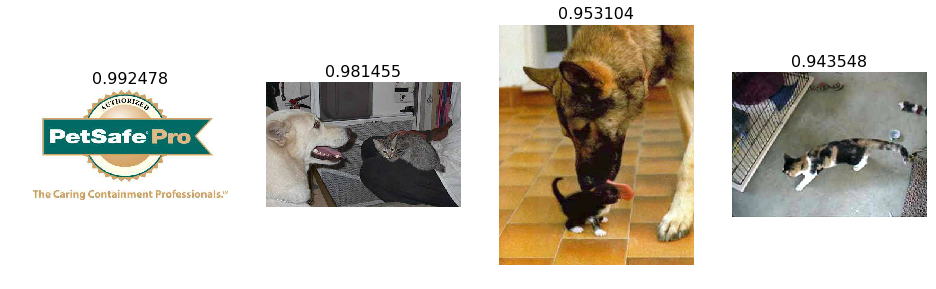

In [68]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats ")

Most incorrect dogs


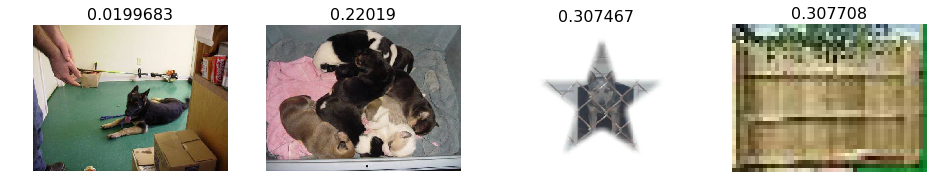

In [71]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [72]:
most_uncertain = np.argsort(np.abs(probs - 0.5 ))[:4]

Most uncertain predictions


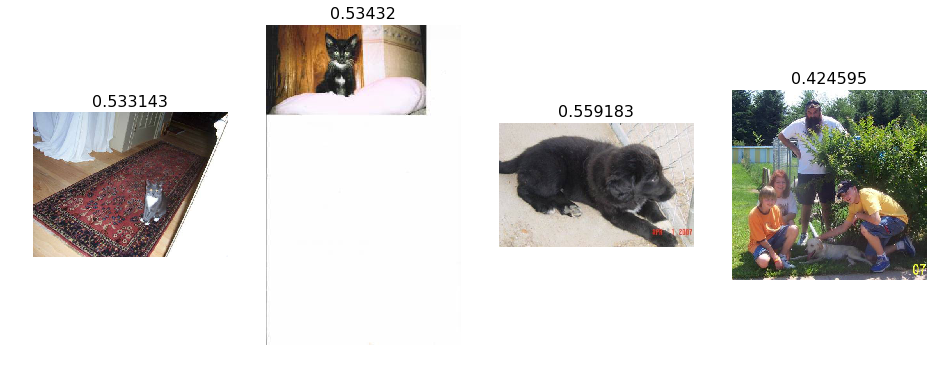

In [73]:
plot_val_with_title(most_uncertain, "Most uncertain predictions")

# Choosing a learning rate 

In [77]:
# use the learn object from before
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

A Jupyter Widget

  3%|▎         | 11/360 [00:00<00:17, 20.31it/s, loss=0.852]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 79%|███████▉  | 286/360 [00:01<00:00, 170.80it/s, loss=0.425]


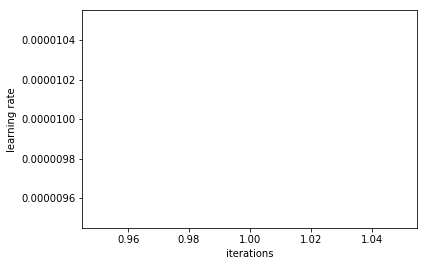

In [75]:
learn.sched.plot_lr()

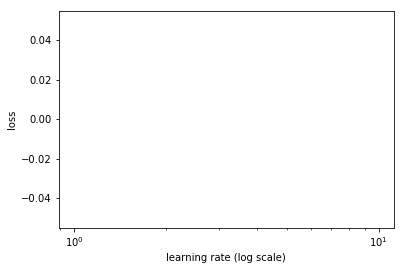

In [76]:
learn.sched.plot()

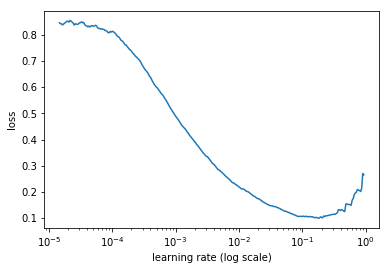

In [78]:
learn.sched.plot()

# This is the scheduled plot 